We think of this if we reach it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy

In [2]:
# Parameters
L = 28  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

In [3]:
# Function that are in previous notebook
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

def update(sys1):
    sys = deepcopy(sys1)
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j] 
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys1, t):
    sys = deepcopy(sys1)
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction

def corrupt_uniform(sys, q): # q probability to flip the pixel
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp

def H(J,sys):
    N = sys.shape[0]
    energy = 0
    for i in range(N):
        for j in range(i):
            energy -= J[i][j]*sys[i]*sys[j]
    return energy

# Mean Field version of dH
def dH(J, sys, k): # k is the index of the spin flipped
    N = sys.shape[0]
    dh = 0
    for i in range(N):
        dh += sys[i]*J[k][i]
    dh *= 2*sys[k]
    return dh

def metropolis(J, sys1, k, B): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = dH(J, sys, k)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys
    
def montecarlo(J, sys1, B, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = metropolis(J, sys, k, B)
    return sys

In [4]:
def from_minst_to_spin(X):
    X = X/255 # Normalizing the values 
    X[ X<0.5 ] = -1
    X[ X>=0.5 ] = 1
    return X

In [5]:
# Just rewrite the path if you want to try it
data_train = pd.read_csv('/Users/Marco/Desktop/data/mnist_train.csv')
data_test = pd.read_csv('/Users/Marco/Desktop/data/mnist_test.csv')

In [6]:
# Actually I didn't use them since they are too much
label_train = []
digits_train = []
for i in range(data_train.shape[0]):
    a = np.array( data_train.iloc[ [i] ])
    label_train.append( a[0][0])
    digits_train.append( a[0][1:] )

label_train = np.array(label_train)
digits_train = np.array(digits_train)
X_train = from_minst_to_spin(digits_train) # from value to {-1,1}

In [7]:
# Used them even if test since less
label_test = []
digits_test = []
for i in range(data_test.shape[0]):
    a = np.array( data_test.iloc[ [i] ])
    label_test.append( a[0][0])
    digits_test.append( a[0][1:] )

label_test = np.array(label_test)
digits_test = np.array(digits_test)
X_test = from_minst_to_spin(digits_test)

In [8]:
# Try with patterns that are the average over all the digits.
# For example take the all 0, sum over the pixel and divide for the number of images.
# If the value is negative -> -1, the other case 1
mean_patterns = []
for i in range(10):
    mean_patterns.append( np.sign(X_test[ label_test == i ].sum(axis=0)) )
mean_patterns = np.array(mean_patterns)

In [9]:
# Just select random samples as patterns
rand_patterns = []
for i in range(10):
    temp = X_test[ label_test == i ].shape[0]
    temp = np.random.randint(0,temp)
    rand_patterns.append( X_test[ label_test == i ][temp] )
rand_patterns = np.array(rand_patterns)

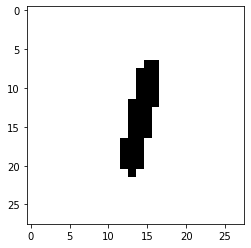

In [10]:
plt.imshow( mean_patterns[1].reshape(L,L), cmap='Greys' )

In [11]:
J = MF_coupling(mean_patterns,N)

The error of the algorithm is 0.183673
The algorithm recognised the pattern 4 and the correct pattern is 2


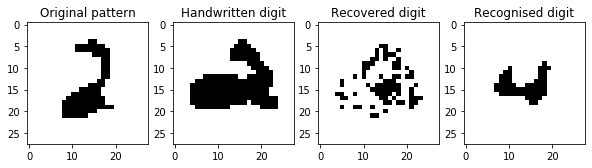

In [12]:
# Average pattern try
# It does not work. Look at it if you want. I think patterns are too much similar
# Also average patterns are not too good. 
idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

res = montecarlo(J,sys,10,1000)

wrong_pixels = error_im(mean_patterns[dgt],sys)
assigned_pattern = assign_pattern(mean_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(mean_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(mean_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [13]:
J = MF_coupling(rand_patterns,N)

The error of the algorithm is 0.192602
The algorithm recognised the pattern 9 and the correct pattern is 6


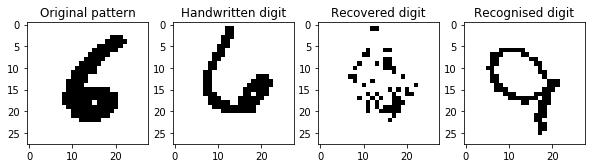

In [14]:
# Random pattern try
# Slightly better, still not good

idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

res = montecarlo(J,sys,1,1000)

wrong_pixels = error_im(rand_patterns[dgt],sys)
assigned_pattern = assign_pattern(rand_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [16]:
# Not sure at all about this function. The idea was: the way of computing the error
# is not the better way in this framework: all the edges are always white, and
# so the error is always small even if it is not working
def minst_error(xi_idx, sys):
    wrong_pixels = (np.abs( sys[ sys == 1 ]-xi_idx[ sys == 1 ] )/2).sum()
    return wrong_pixels/len(sys[ sys == 1 ])

The error of the algorithm is 0.887640
The algorithm recognised the pattern 4 and the correct pattern is 5


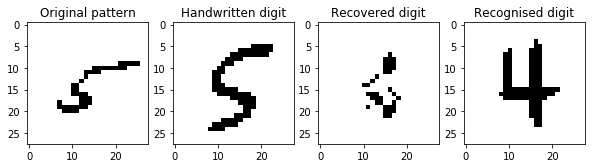

In [17]:
# tried deterministic instead of stochastic. Worse than the other and TOO MUCH TIME
idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

res = deterministic_hopfield(sys,30)

wrong_pixels = minst_error(rand_patterns[dgt],sys)
assigned_pattern = assign_pattern(rand_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [18]:
# Just thought that maybe there was too much pixels to understand the behaviour.
# This function takes batches of four pixels and from them create a single pixel
# that is black if even only one of that four is black.
# This divides by 4 the resolution of the image, 28x28->14x14

def zipping(sys1):
    sys = deepcopy(sys1)
    N = sys.shape[0]
    L = int(np.sqrt(N))
    sys = sys.reshape(L,L)
    zipp = np.array([-1 for i in range(N//4)]).reshape(L//2,L//2)
    for i in np.arange(0, L, 2):
        for j in np.arange(0, L, 2):
            if sys[i][j] + sys[i+1][j] + sys[i][j+1] + sys[i+1][j+1] > -4:
                zipp[i//2,j//2] = 1
    zipp = zipp.reshape(1,N//4)
    return zipp[0]

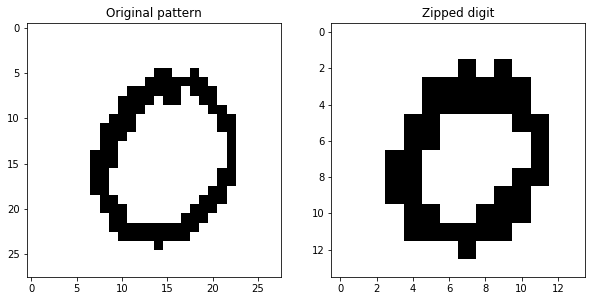

In [19]:
# Simply look at the outcome
idx = 100
dgt = label_test[idx]
sys = X_test[idx]

zip_dgt = zipping(sys)

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(sys.reshape(L,L),cmap='Greys')
ax[1].set_title('Zipped digit')
ax[1].imshow(zip_dgt.reshape(L//2,L//2),cmap='Greys')

In [20]:
# Yeah, you know I really love to use the word stuff. I was only upset that this 
# stuff wasn't working. Here I zip all the test data.
stuff = []
for i in X_test:
    stuff.append( zipping(i) )
stuff = np.array(stuff)

In [21]:
# Inizialize the old variables using the new zipped samples.

rand_patterns = []
for i in range(10):
    temp = stuff[ label_test == i ].shape[0]
    temp = np.random.randint(0,temp)
    rand_patterns.append( stuff[ label_test == i ][temp] )
rand_patterns = np.array(rand_patterns)

n = N//4
J = MF_coupling(rand_patterns,n)

The error of the algorithm is 0.168367
The algorithm recognised the pattern 2 and the correct pattern is 2


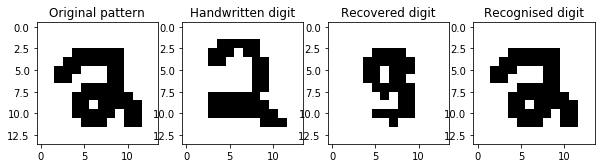

In [22]:
# Tried to run the algorithm again.
# Still bad result.
# Quite upset.

idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = stuff[idx]

res = montecarlo(J,sys,1,1000)

wrong_pixels = error_im(rand_patterns[dgt],sys)
assigned_pattern = assign_pattern(rand_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L//2,L//2),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L//2,L//2),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L//2,L//2),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L//2,L//2),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))